In [26]:
import os
import time
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.transforms.functional import to_pil_image
from transformers import SegformerForSemanticSegmentation
from PIL import Image
import tifffile as tiff
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
import torch.nn as nn

In [27]:
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True):
        super().__init__()
        
        # Loop through the files in the red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, r_file: Path, g_dir, b_dir, nir_dir, gt_dir):
        # Combine file paths for different spectral bands into a dictionary
        files = {'red': r_file, 
                 'green': g_dir / r_file.name.replace('red', 'green'),
                 'blue': b_dir / r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir / r_file.name.replace('red', 'nir'),
                 'gt': gt_dir / r_file.name.replace('red', 'gt')}
        return files
                                       
    def __len__(self):
        # Return the number of files in the dataset
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):
        # Open image files as arrays, optionally including NIR channel
        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
    
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2, 0, 1))
    
        # Normalize pixel values
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    
    def open_mask(self, idx, add_dims=False):
        # Open ground truth mask as an array
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask == 255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        # Get an item from the dataset (image and mask)
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.int64)
        
        return x, y
    
    def open_as_pil(self, idx):
        # Open an image as a PIL image
        arr = 256 * self.open_as_array(idx)
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        # Return a string representation of the dataset
        s = 'Dataset class with {} files'.format(self.__len__())
        return s

In [28]:

# --- CONFIG ---
data_path = Path("C:/Users/capta/Documents/KaleidEO/38-Cloud_training")
num_classes = 2
batch_size = 4
epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Dataset & Dataloader ---
dataset = CloudDataset(
    data_path/'train_red',
    data_path/'train_green',
    data_path/'train_blue',
    data_path/'train_nir',
    data_path/'train_gt'
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# --- Load Pretrained SegFormer Model ---
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

# --- Modify First Conv Layer to Accept 4 Channels ---
old_conv = model.segformer.encoder.patch_embeddings[0].proj
new_conv = nn.Conv2d(
    in_channels=4,
    out_channels=old_conv.out_channels,
    kernel_size=old_conv.kernel_size,
    stride=old_conv.stride,
    padding=old_conv.padding
)

with torch.no_grad():
    new_conv.weight[:, :3] = old_conv.weight  # Copy RGB weights
    new_conv.weight[:, 3] = old_conv.weight.mean(dim=1)  # Init NIR as mean of RGB

model.segformer.encoder.patch_embeddings[0].proj = new_conv
model.to(device)

# --- Optimizer & Loss ---
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


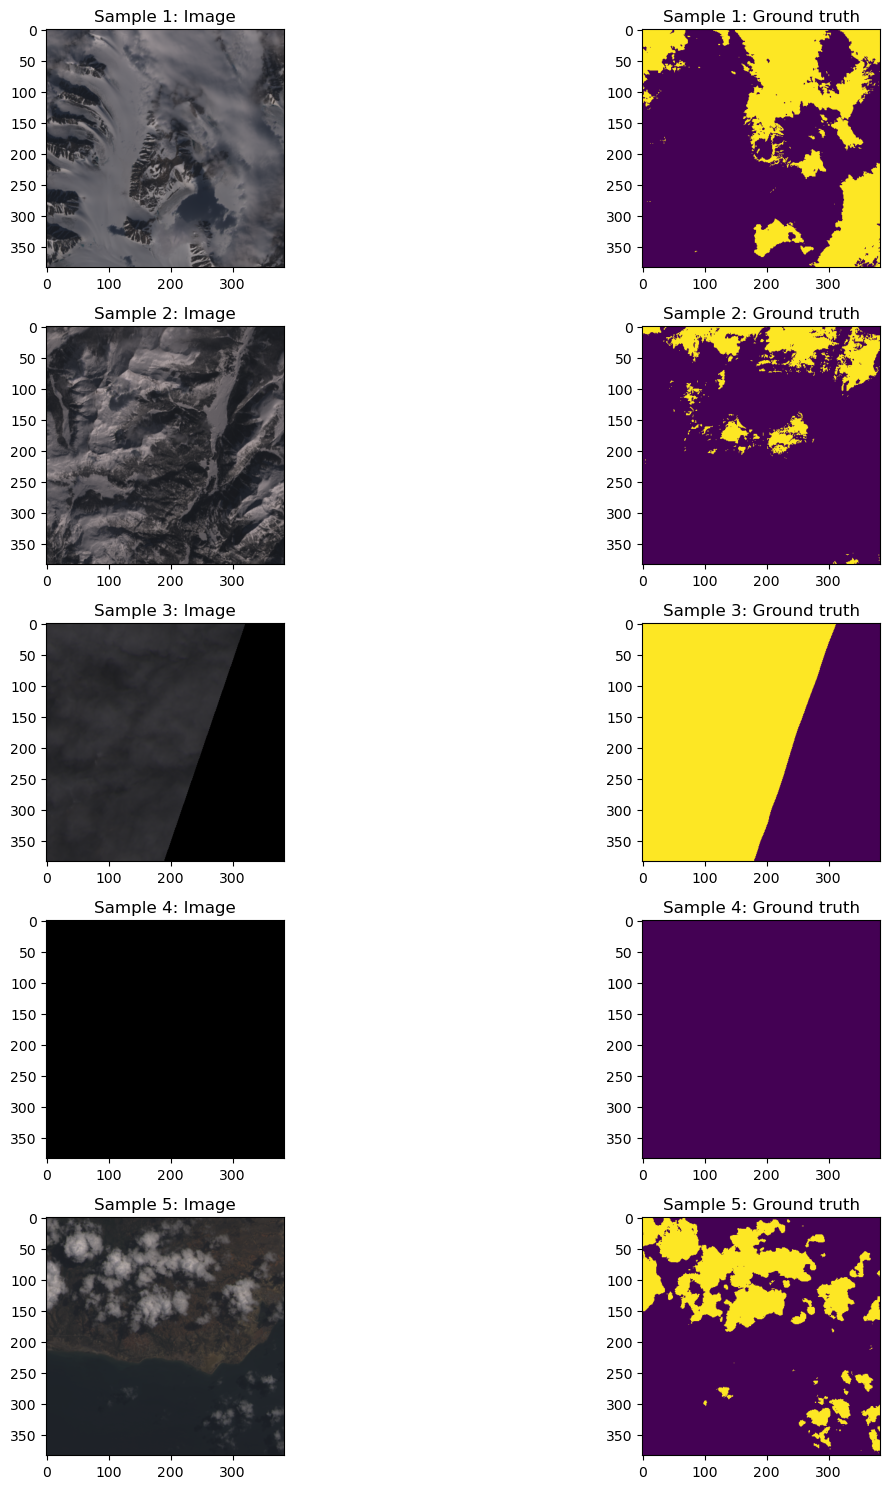

In [ ]:
# Create a subplot grid for displaying the images and masks
fig, ax = plt.subplots(5, 2, figsize=(15, 15))

# Generate 5 random sample indices
sample_indices = random.sample(range(len(dataset)), 5)

# Iterate through the sample indices and display images and masks
for i, idx in enumerate(sample_indices):
    ax[i, 0].imshow(dataset.open_as_array(idx))
    ax[i, 0].set_title(f'Sample {i + 1}: Image')
    
    ax[i, 1].imshow(dataset.open_mask(idx))
    ax[i, 1].set_title(f'Sample {i + 1}: Ground truth')

plt.tight_layout()
plt.show()

In [30]:
# --- Evaluation Metrics ---
def iou_score(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def dice_score(pred, target, threshold=0.5):
    pred = (pred > threshold).float()
    intersection = (pred * target).sum()
    return (2 * intersection + 1e-6) / (pred.sum() + target.sum() + 1e-6)

# --- Setup Paths ---
base_path = Path('C:/Users/capta/Documents/KaleidEO/38-Cloud_training')
data = CloudDataset(base_path/'train_red', base_path/'train_green', base_path/'train_blue', base_path/'train_nir', base_path/'train_gt')

# --- Split Dataset ---
train_size = int(0.8 * len(data))
val_size = len(data) - train_size
train_data, val_data = random_split(data, [train_size, val_size])

# --- Data Loaders ---
batch_size = 8
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, pin_memory=True)

# --- Model Setup ---
num_classes = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=num_classes,
    ignore_mismatched_sizes=True
)

# --- Modify Input Channels to 4 ---
with torch.no_grad():
    old_conv = model.segformer.encoder.patch_embeddings[0].proj
    new_conv = torch.nn.Conv2d(4, old_conv.out_channels, kernel_size=old_conv.kernel_size, stride=old_conv.stride, padding=old_conv.padding)
    new_conv.weight[:, :3] = old_conv.weight
    torch.nn.init.kaiming_normal_(new_conv.weight[:, 3:])
    model.segformer.encoder.patch_embeddings[0].proj = new_conv

model.to(device)

# --- Optimizer & Loss ---
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4)
criterion = torch.nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler() 


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\capta\AppData\Local\Temp\ipykernel_91316\1037830698.py:49: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [31]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [32]:
xb, yb = next(iter(val_loader))

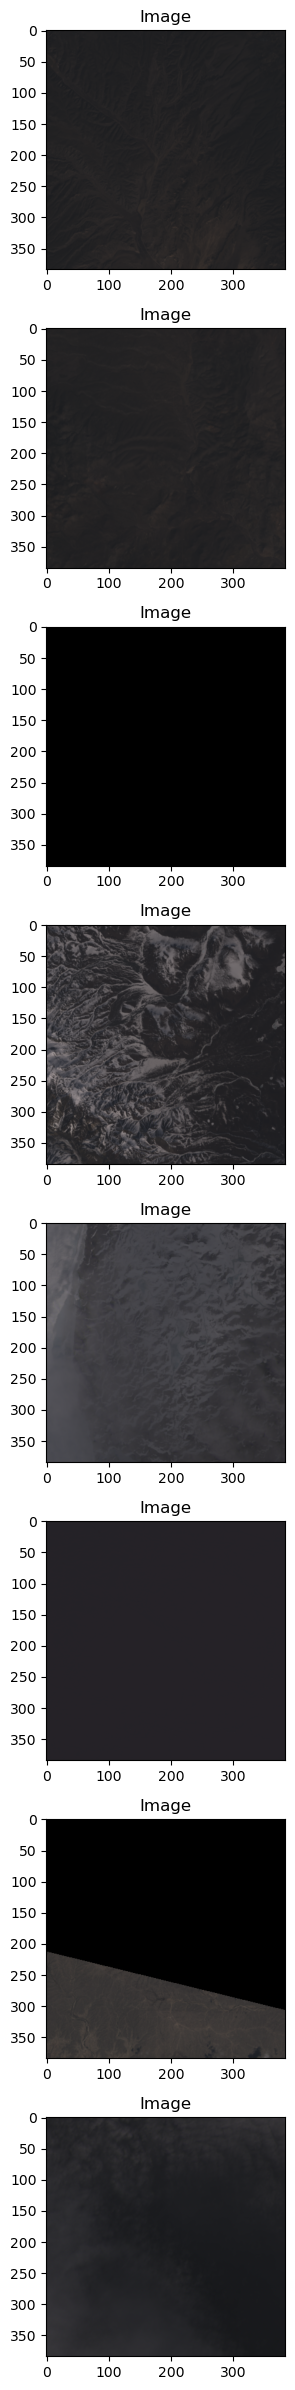

In [33]:
bs = xb.shape[0]
fig, ax = plt.subplots(bs, 1, figsize=(15, bs * 3))

ax = ax.reshape(bs, 1)
for i in range(bs):
    # Image
    ax[i, 0].imshow(batch_to_img(xb, i))
    ax[i, 0].set_title("Image")

plt.tight_layout()
plt.show()

In [56]:
train_losses = []
val_losses = []
val_ious = []
val_dices = []
val_accuracies = []

In [57]:
# --- Training Loop ---
num_epochs = 10
best_iou = 0.0

for epoch in range(num_epochs):
    start = time.time()
    model.train()
    running_loss = 0

    for xb, yb in tqdm(train_loader):
        optimizer.zero_grad()
        xb, yb = xb.to(device), yb.to(device)

        with torch.cuda.amp.autocast():
            logits = model(pixel_values=xb).logits
            logits = torch.nn.functional.interpolate(logits, size=yb.shape[1:], mode="bilinear", align_corners=False)
            loss = criterion(logits, yb)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    ious, dices = [], []
    accs, val_loss = [], 0.0

    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(pixel_values=xb).logits
            logits = torch.nn.functional.interpolate(logits, size=yb.shape[1:], mode="bilinear", align_corners=False)

            loss = criterion(logits, yb)
            val_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            for p, t in zip(preds, yb):
                ious.append(iou_score(p, t))
                dices.append(dice_score(p, t))
                accs.append((p == t).float().mean().item())

    avg_iou = sum(ious) / len(ious)
    avg_dice = sum(dices) / len(dices)

    avg_val_loss = val_loss / len(val_loader)
    avg_acc = sum(accs) / len(accs)

    val_losses.append(avg_val_loss)
    val_ious.append(avg_iou.item())
    val_dices.append(avg_dice.item())
    val_accuracies.append(avg_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, IoU: {avg_iou:.4f}, Dice: {avg_dice:.4f}, Acc: {avg_acc:.4f}, Time: {time.time() - start:.2f}s")

    if avg_iou > best_iou:
        best_iou = avg_iou
        torch.save(model.state_dict(), "best_segformer.pth")
        print("\u2705 Saved new best model")

# --- Prediction Example ---
model.load_state_dict(torch.load("best_segformer.pth"))
model.eval()
output_dir = Path("predicted_masks")
output_dir.mkdir(exist_ok=True)

with torch.no_grad():
    for i, (xb, _) in enumerate(val_loader):
        xb = xb.to(device)
        logits = model(pixel_values=xb).logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        for j in range(preds.shape[0]):
            pred_mask = preds[j].astype(np.uint8)
            tiff.imwrite(str(output_dir / f"mask_{i * batch_size + j}.tif"), pred_mask * 255)
        break  # Just predict one batch to test output


  0%|          | 0/840 [00:00<?, ?it/s]

C:\Users\capta\AppData\Local\Temp\ipykernel_91316\3583042441.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 840/840 [09:40<00:00,  1.45it/s]


Epoch 1/10, Train Loss: 0.1115, Val Loss: 0.0811, IoU: 0.8476, Dice: 0.8762, Acc: 0.9672, Time: 733.23s
✅ Saved new best model


100%|██████████| 840/840 [03:42<00:00,  3.78it/s]


Epoch 2/10, Train Loss: 0.1098, Val Loss: 0.0934, IoU: 0.8402, Dice: 0.8700, Acc: 0.9641, Time: 271.19s


100%|██████████| 840/840 [03:44<00:00,  3.75it/s]


Epoch 3/10, Train Loss: 0.0958, Val Loss: 0.0718, IoU: 0.8525, Dice: 0.8803, Acc: 0.9719, Time: 271.52s
✅ Saved new best model


100%|██████████| 840/840 [04:55<00:00,  2.84it/s]


Epoch 4/10, Train Loss: 0.0972, Val Loss: 0.0723, IoU: 0.8554, Dice: 0.8822, Acc: 0.9714, Time: 360.10s
✅ Saved new best model


100%|██████████| 840/840 [09:48<00:00,  1.43it/s]


Epoch 5/10, Train Loss: 0.0924, Val Loss: 0.0848, IoU: 0.8476, Dice: 0.8768, Acc: 0.9662, Time: 798.91s


100%|██████████| 840/840 [8:58:20<00:00, 38.45s/it]      


Epoch 6/10, Train Loss: 0.0862, Val Loss: 0.1064, IoU: 0.8157, Dice: 0.8463, Acc: 0.9587, Time: 32494.24s


100%|██████████| 840/840 [51:11<00:00,  3.66s/it]    


Epoch 7/10, Train Loss: 0.0906, Val Loss: 0.0676, IoU: 0.8658, Dice: 0.8924, Acc: 0.9737, Time: 6785.87s
✅ Saved new best model


100%|██████████| 840/840 [08:03<00:00,  1.74it/s]


Epoch 8/10, Train Loss: 0.0833, Val Loss: 0.0922, IoU: 0.8398, Dice: 0.8687, Acc: 0.9648, Time: 533.28s


100%|██████████| 840/840 [03:40<00:00,  3.80it/s]


Epoch 9/10, Train Loss: 0.0711, Val Loss: 0.0677, IoU: 0.8665, Dice: 0.8932, Acc: 0.9727, Time: 270.20s
✅ Saved new best model


100%|██████████| 840/840 [03:58<00:00,  3.53it/s]


Epoch 10/10, Train Loss: 0.0727, Val Loss: 0.0667, IoU: 0.8639, Dice: 0.8895, Acc: 0.9745, Time: 284.85s


C:\Users\capta\AppData\Local\Temp\ipykernel_91316\3583042441.py:66: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_segformer.pth"))


In [58]:
# --- Visualize Predictions ---
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [64]:
xb, yb = next(iter(val_loader))

# Model prediction
with torch.no_grad():
    predb = model(pixel_values=xb.to(device)).logits
    predb = torch.nn.functional.interpolate(predb, size=yb.shape[-2:], mode="bilinear", align_corners=False)

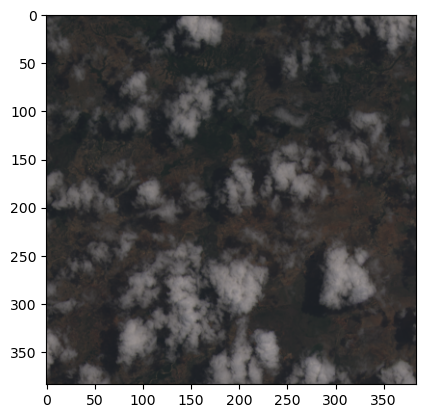

In [65]:
xb.shape, yb.shape, predb.shape
plt.imshow(batch_to_img(xb, 3))

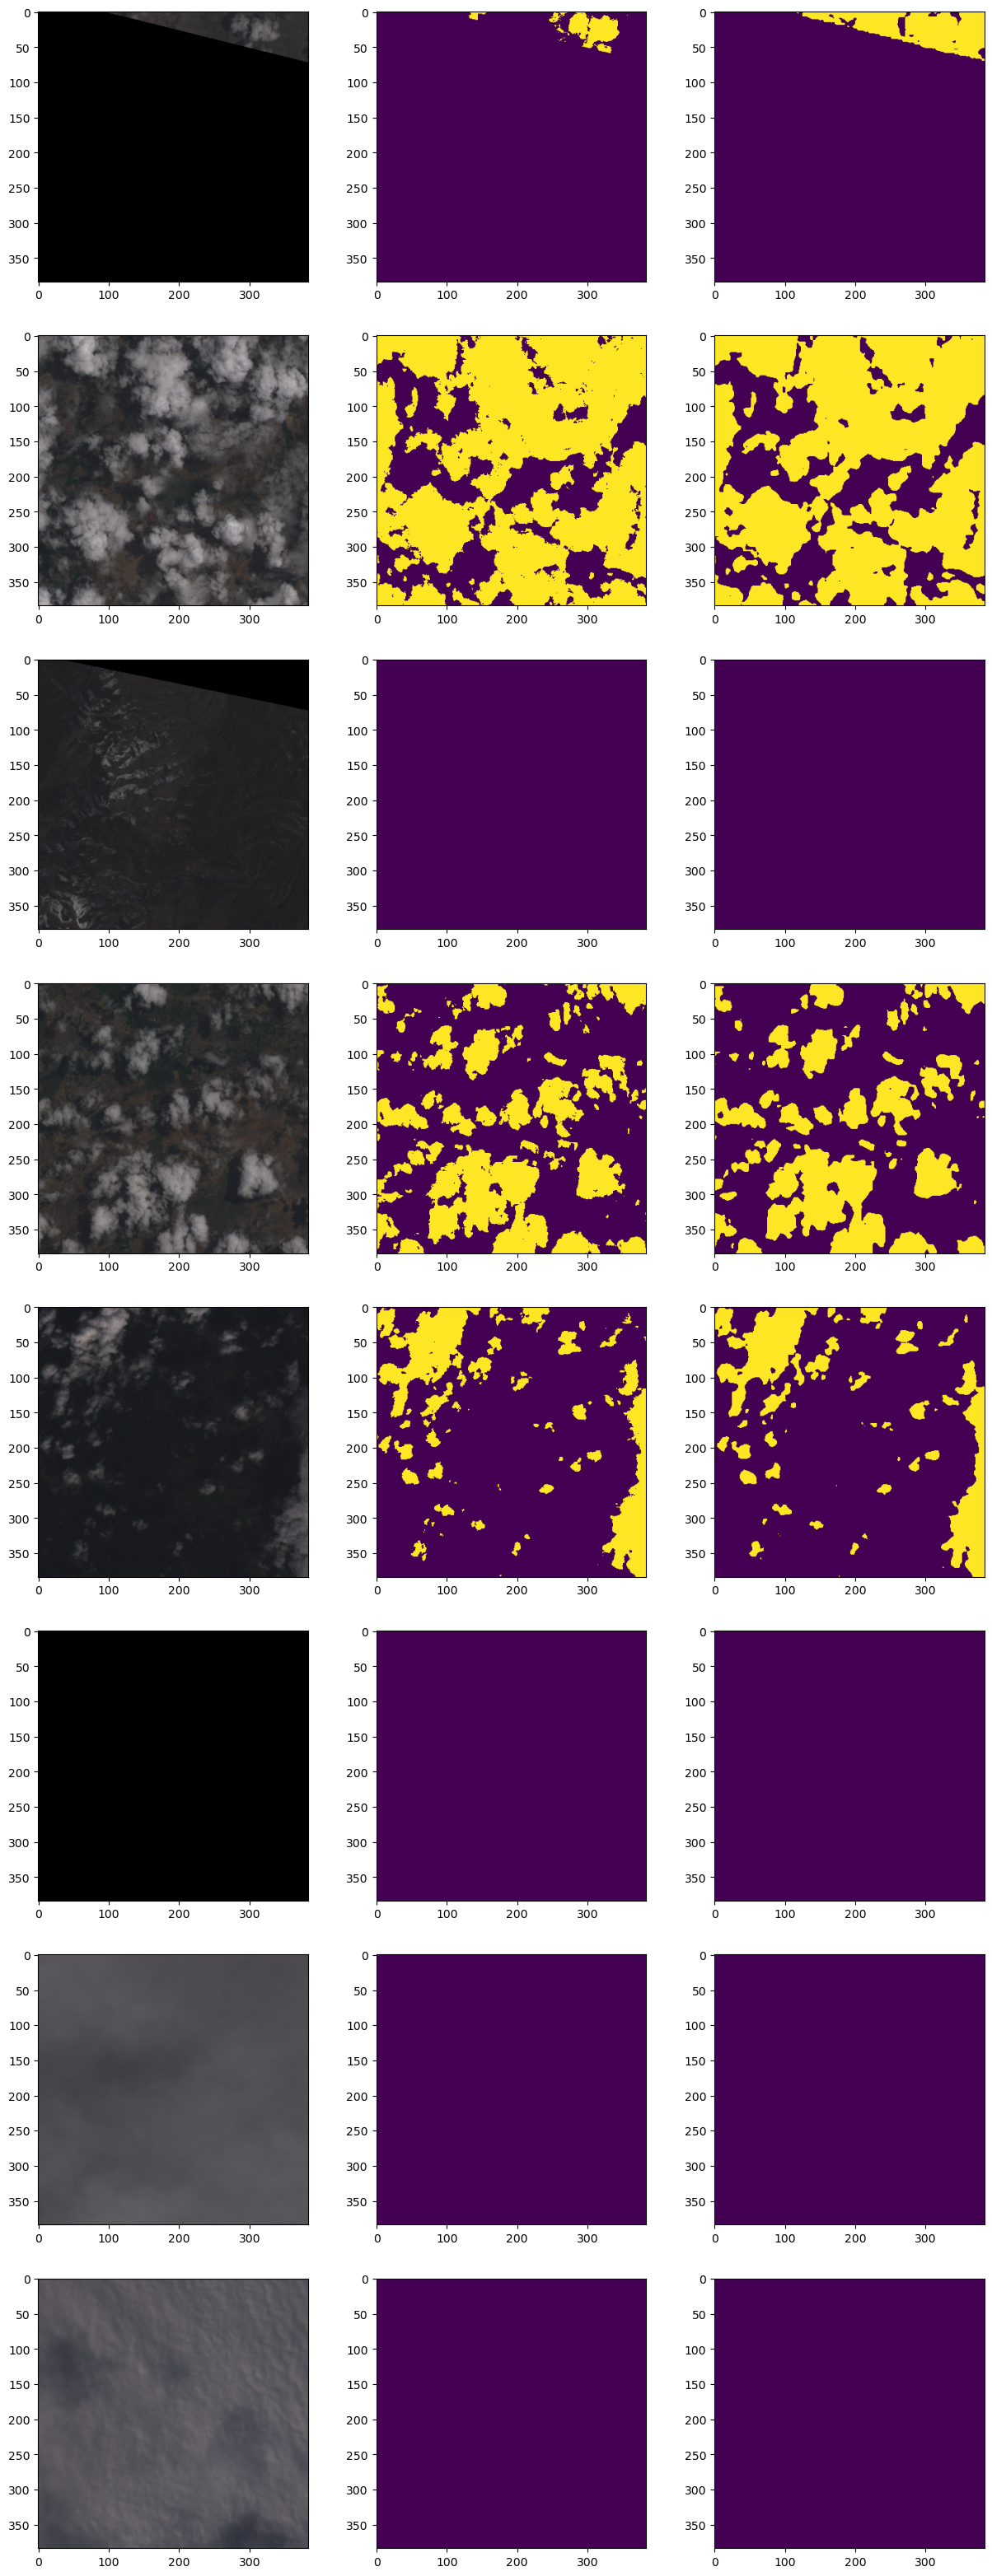

In [66]:
bs = 8
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

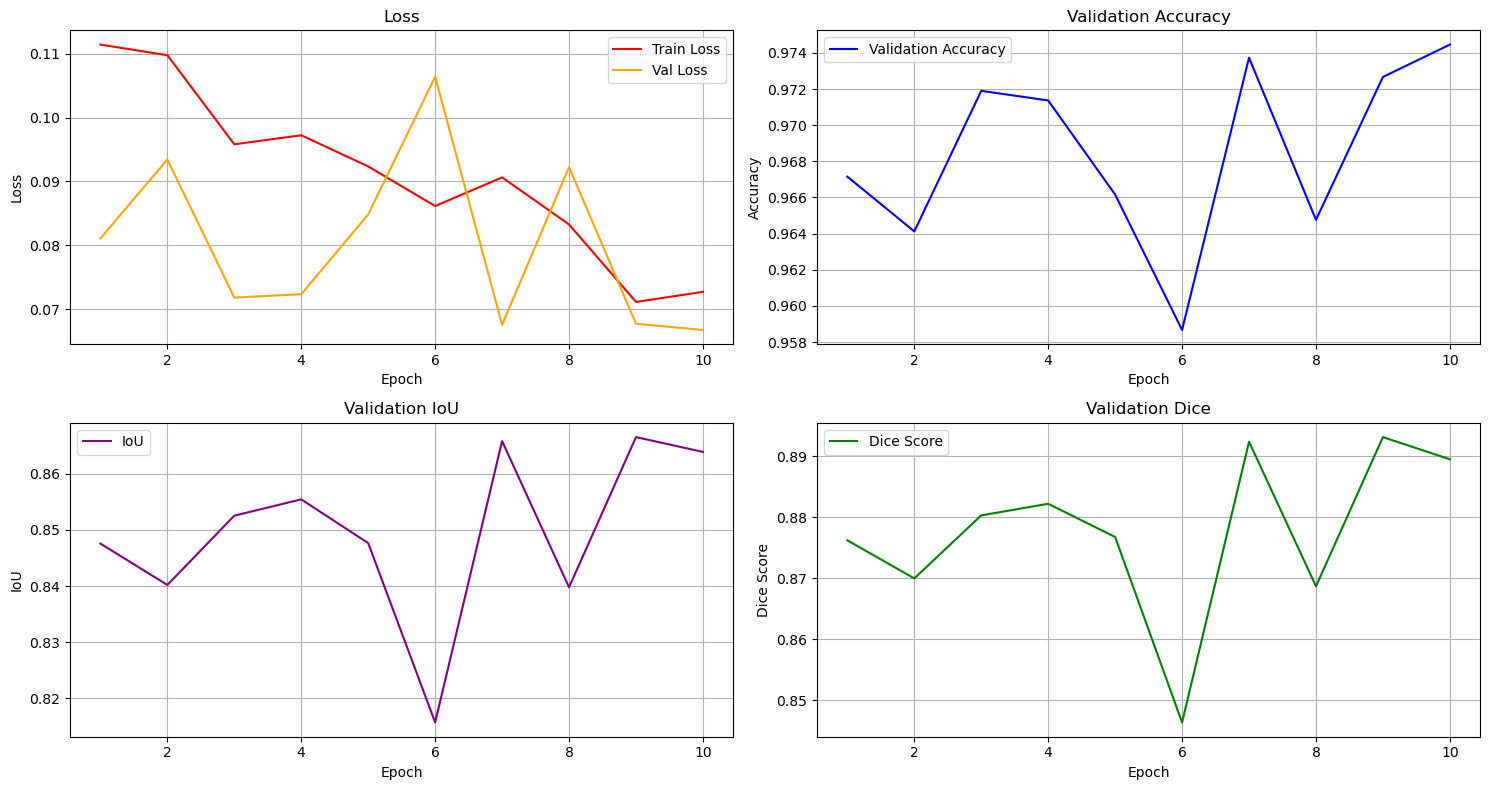

In [67]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(15, 8))

# --- Losses ---
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='red')
plt.plot(epochs, val_losses, label='Val Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

# --- Accuracy ---
plt.subplot(2, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.grid(True)

# --- IoU ---
plt.subplot(2, 2, 3)
#val_ious = [v.item() if v.numel() == 1 else v.cpu().numpy() for v in val_ious]
plt.plot(epochs, val_ious, label='IoU', color='purple')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Validation IoU')
plt.legend()
plt.grid(True)

# --- Dice ---
plt.subplot(2, 2, 4)
#val_dices = [v.item() if v.numel() == 1 else v.cpu().numpy() for v in val_dices]
plt.plot(epochs, val_dices, label='Dice Score', color='green')
plt.xlabel('Epoch')
plt.ylabel('Dice Score')
plt.title('Validation Dice')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
